In [1]:
import mne
import pickle

In [2]:
with open('bcci_data_preprocessed.pkl','rb') as f:
    dataset=pickle.load(f)

print("Preprocessed data has been loaded from 'bcci_data_preprocessed.pkl'")

C:\Users\dyuti\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Preprocessed data has been loaded from 'bcci_data_preprocessed.pkl'


In [3]:
input_window_samples = 1000

In [4]:
import torch

from braindecode.models import Deep4Net
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]



In [ ]:
model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    _ = model.cuda()

In [6]:
model.to_dense_prediction_model()

In [7]:
n_preds_per_input = model.get_output_shape()[2]

In [8]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [9]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
valid_set = splitted['1test'] 

In [10]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training import CroppedLoss

# For deep4 they should be:
lr = 1 * 0.01
weight_decay = 0.5 * 0.001

batch_size=64
n_epochs=30

In [10]:
clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_schedu6ler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr        dur
-------  ----------------  ------------  ----------------  ------------  ------  ---------
      1            0.3376        1.9258            0.3492        1.4498  0.0100  1018.2908
      2            0.4680        1.4566            0.4425        1.3858  0.0100  1024.7258
      3            0.4309        1.2208            0.4051        1.4730  0.0099  1016.7769
      4            0.4691        1.1464            0.4583        1.2180  0.0097  956.9958
      5            0.5000        1.0934            0.4688        1.2511  0.0095  336.9560
      6            0.5903        1.0427            0.5467        1.0929  0.0093  344.4031
      7            0.5208        1.0002            0.4568        1.2760  0.0090  342.8073
      8            0.5201        0.9752            0.4965        1.3796  0.0086  352.7138
      9            0.5756        0.9555            0.5332        1.1284  0.0082  341.0698
     

In [12]:
import joblib

In [13]:
file1='Ablation_deep_original.sav'

In [13]:
joblib.dump(clf,file1)

['Ablation_deep_original.sav']

In [14]:
clf_original=joblib.load(file1)

C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


## Ablation Study

#### 1.No Dropout

In [5]:
model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    drop_prob=0
)
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
Deep4Net (Deep4Net)                      [1, 23, 1000]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 23, 1000]             [1, 23, 1000, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 23, 1000, 1]          [1, 1, 1000, 23]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 23]          [1, 25, 991, 1]           14,650                    --
├─BatchNorm2d (bnorm): 1-4               [1, 25, 991, 1]           [1, 25, 991, 1]           50                        --
├─Expression (conv_nonlin): 1-5          [1, 25, 991, 1]           [1, 25, 991, 1]           --                        --
├─MaxPool2d (pool): 1-6                  [1, 25, 991, 1]           [1, 25, 330, 1]           --                        [3, 1]
├─Expressi

C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [11]:
clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_schedu6ler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr       dur
-------  ----------------  ------------  ----------------  ------------  ------  --------
      1            0.2959        1.8150            0.3056        1.7193  0.0100  973.8130
      2            0.4008        1.2966            0.3858        2.2234  0.0100  1002.2676
      3            0.2500        1.1428            0.2500        6.8319  0.0099  1008.2013
      4            0.4248        1.0429            0.3881        2.1839  0.0097  983.4921
      5            0.5748        0.9578            0.5162        1.3089  0.0095  781.7417
      6            0.5965        0.8557            0.5282        1.3738  0.0093  791.7655
      7            0.3364        0.8089            0.3210        3.4707  0.0090  782.5821
      8            0.6007        0.6669            0.5093        2.3404  0.0086  790.9144
      9            0.4649        0.5998            0.4093        3.1160  0.0082  541.4166
     10 

In [23]:
file2='deep_clf_no_dropout.sav'

In [24]:
joblib.dump(clf,file2)

['deep_clf_no_dropout.sav']

In [7]:
clf_no_dropout=joblib.load(file2)

C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


#### 2.No dropout and Batch norm

In [18]:
model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    batch_norm_alpha=0,
    drop_prob=0  
)


C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:23: UserWarning: Deep4Net: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\dyuti\anaconda3\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [24]:
clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_schedu6ler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr       dur
-------  ----------------  ------------  ----------------  ------------  ------  --------
      1            0.2500        1.7756            0.2500     1827.5361  0.0100  746.4396
      2            0.2500        1.3595            0.2500     4049.7071  0.0100  729.9395
      3            0.2500        1.1664            0.2500     1488.9921  0.0099  969.2359
      4            0.2500        1.0277            0.2500      925.1508  0.0097  647.8400
      5            0.2500        0.9727            0.2500     2427.1361  0.0095  634.0468
      6            0.2500        0.8786            0.2500     2532.2721  0.0093  2001.0610
      7            0.2500        0.8148            0.2500     1915.4292  0.0090  2002.2029
      8            0.2948        0.6890            0.2812     2188.4242  0.0086  1548.6706
      9            0.2500        0.5713            0.2500     3304.2507  0.0082  599.9817
     10

In [15]:
file3='Deep_clf_no_both.sav'

In [28]:
joblib.dump(clf,file3)

['Deep_clf_no_both.sav']

In [16]:
clf_no_both=joblib.load(file3)

C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


### 3. No batch norm

In [17]:
file4='Deep_clf_no_batch_norm.sav'

In [18]:
clf_no_batch_norm=joblib.load(file4)

C:\Users\dyuti\anaconda3\Lib\site-packages\skorch\net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


 ### Visualization

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Function to extract accuracy and loss for plotting
def extract_metrics(clf):
    results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
    df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns, index=clf.history[:, 'epoch'])
    # Misclassification for better visual comparison
    df = df.assign(train_misclass=100 - 100 * df.train_accuracy, valid_misclass=100 - 100 * df.valid_accuracy)
    return df

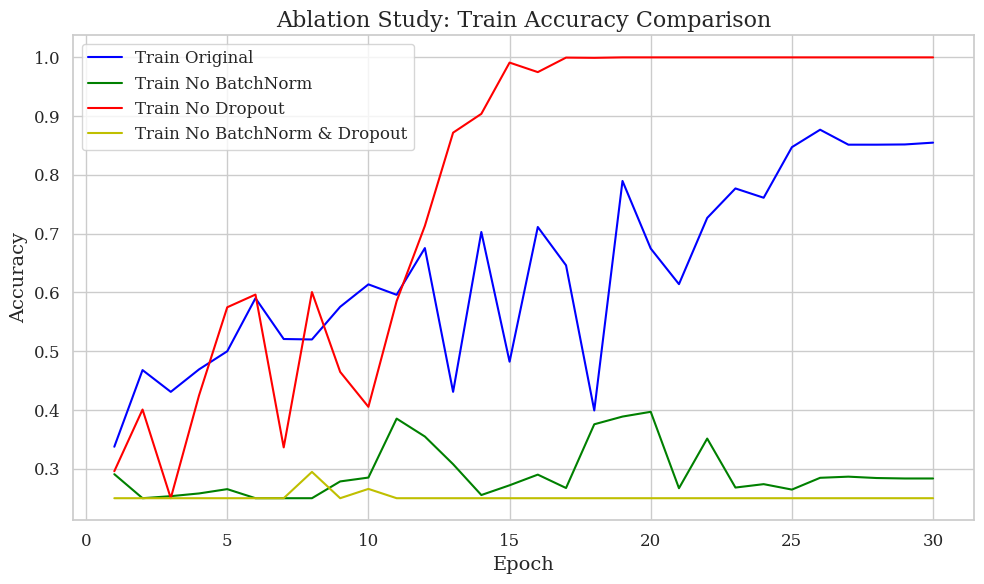

In [21]:
# Load the accuracies and losses for each model
df_original = extract_metrics(clf_original)
df_no_batch_norm = extract_metrics(clf_no_batch_norm)
df_no_dropout = extract_metrics(clf_no_dropout)
df_no_both = extract_metrics(clf_no_both)

# Plotting accuracy comparisons across modelsimport matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Function to extract accuracy and loss for plotting
def extract_metrics(clf):
    results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
    df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns, index=clf.history[:, 'epoch'])
    # Misclassification for better visual comparison
    df = df.assign(train_misclass=100 - 100 * df.train_accuracy, valid_misclass=100 - 100 * df.valid_accuracy)
    return df
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot the original model accuracies
ax1.plot(df_original.index, df_original['train_accuracy'],'b-',label='Train Original')

# Plot the no batch normalization model accuracies
ax1.plot(df_no_batch_norm.index, df_no_batch_norm['train_accuracy'], 'g-', label='Train No BatchNorm')

# Plot the no dropout model accuracies
ax1.plot(df_no_dropout.index, df_no_dropout['train_accuracy'], 'r-', label='Train No Dropout')

# Plot the no batch normalization + no dropout model accuracies
ax1.plot(df_no_both.index, df_no_both['train_accuracy'], 'y-', label='Train No BatchNorm & Dropout')

# Set labels and title
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.set_title('Ablation Study: Train Accuracy Comparison', fontsize=16)
ax1.legend(loc='upper left', fontsize=12)

# Customize ticks and grid
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True)

plt.tight_layout()
plt.show()


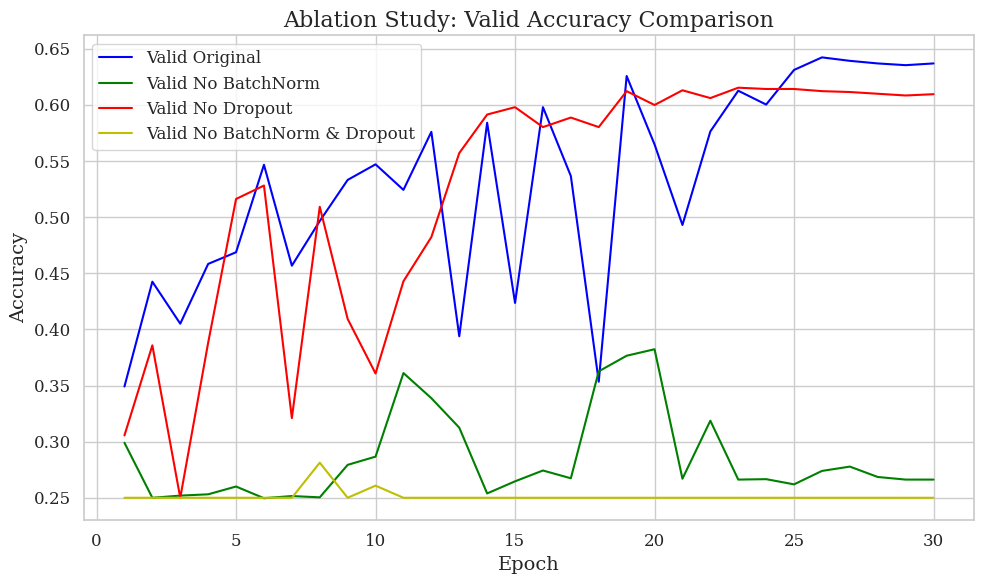

In [22]:
# Plotting accuracy comparisons across models
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the original model accuracies
ax1.plot(df_original.index, df_original['valid_accuracy'], 'b-', label='Valid Original')
ax1.plot(df_no_batch_norm.index, df_no_batch_norm['valid_accuracy'], 'g-', label='Valid No BatchNorm')
ax1.plot(df_no_dropout.index, df_no_dropout['valid_accuracy'], 'r-', label='Valid No Dropout')
ax1.plot(df_no_both.index, df_no_both['valid_accuracy'], 'y-', label='Valid No BatchNorm & Dropout')

ax1.set_xlabel('Epoch',fontsize=14)
ax1.set_ylabel('Accuracy',fontsize=14)
ax1.set_title('Ablation Study: Valid Accuracy Comparison',fontsize=16)
ax1.legend(loc='upper left',fontsize=12)

# Customize ticks and grid
ax1.tick_params(axis='x',labelsize=12)
ax1.tick_params(axis='y',labelsize=12)
ax1.grid(True)

plt.tight_layout()
plt.show()


In [21]:
df_original

,train_loss,valid_loss,train_accuracy,valid_accuracy,train_misclass,valid_misclass
1,1.925821,1.449804,0.337577,0.349151,66.242284,65.084877
2,1.456603,1.385812,0.467978,0.442515,53.202160,55.748457
3,1.220771,1.472991,0.430941,0.405093,56.905864,59.490741
4,1.146353,1.217965,0.469136,0.458333,53.086420,54.166667
5,1.093422,1.251107,0.500000,0.468750,50.000000,53.125000
6,1.042747,1.092919,0.590278,0.546682,40.972222,45.331790
7,1.000228,1.276010,0.520833,0.456790,47.916667,54.320988
8,0.975199,1.379637,0.520062,0.496528,47.993827,50.347222
9,0.955481,1.128356,0.575617,0.533179,42.438272,46.682099
10,0.938053,1.150752,0.613812,0.547068,38.618827,45.293210


In [40]:
clf

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  Deep4Net (Deep4Net)                      [1, 23, 1000]             [1, 4, 74]                --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 23, 1000]             [1, 23, 1000, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 23, 1000, 1]          [1, 1, 1000, 23]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 23]          [1, 25, 991, 1]           14,650                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 25, 991, 1]           [1, 25, 991, 1]           50                        --
  ├─Expression (conv_nonlin): 1-5 